<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Filter_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Notebook designed by Nicolas Menet in collaboration with Guy Revach.*

# FIR Filters vs IIR Filters

## FIR Filter design with Han windows

We follow the example on page 57 in the lecture notes (as of 2020)

We wish to design an ideal discrete-time lowpass filter with frequency response $H(e^{i\Omega}) = \begin{cases} 1 & |\Omega | < \Omega_c\\ 0 & otherwise \end{cases}$. 

Using the inversion formula we get in the time domain $h[k] = \frac{\sin(\Omega_c k)}{\pi k}$. You may notice that $h$ is unstable and thus not suitable in real world applications. To the rescue comes the Hann window function (here for even $N$) given by $w[k] = \begin{cases} \frac{1}{2}(1+\cos(\frac{2\pi k}{N+2}) & |k| \leq \frac{N}{2}\\ 0 & |k| > \frac{N}{2}\end{cases}$. Multiplication of $h$ by $w$ yields a bounded finite-duration signal, which is stable. Nicely $W(\Omega)$ is "almost" a dirac delta function, thus $H(\Omega) * W(\Omega) \approx H(\Omega)$, so the low-pass filter is minimally distorted. A subsequent normalization gives a unit amplification in the passband. We get for the final filter $h_w[k] = \frac{h[k] w[k]}{\sum\limits_{n\in\mathbb{Z}} h[n] w[n]}$. If we wish to have a causal filter we may delay our result to get $g[k] = h_w[k-N/2]$.

In [1]:
pip install pydsm

     |████████████████████████████████| 552 kB 4.9 MB/s 
  Created wheel for pydsm: filename=pydsm-0.14.0.0-cp37-cp37m-linux_x86_64.whl size=684706 sha256=f26fe8c76ff218222fbbef590290f02bcf6228f1b23c1311197a8d4fd35eb6e2
  Stored in directory: /root/.cache/pip/wheels/1d/37/8e/15939ed2fb3dcf8bbab167a0bf7c7155c2e6fa4df16d490260
Successfully built pydsm


In [2]:
import ipywidgets as widgets
import numpy as np
from pydsm.ft import dtft
import matplotlib.pyplot as plt
%matplotlib inline
#-------------------------------------------------------------------------------

#Important Stuff
################################################################################
def H(Omega, Omega_c):
  if np.abs(Omega) < Omega_c:
    return 1
  else:
    return 0

def h(k, Omega_c):
  if k == 0:
    return Omega_c/np.pi
  else:
    return np.sin(Omega_c*k)/(np.pi*k)

def w(k, N):#returns single value w[k]
  assert N % 2 == 0, "N should be even"
  if np.abs(k) > N/2:
    return 0
  else:
    return (1+np.cos((2*np.pi*k)/(N+2)))/2

def W(N):#returns callable function of frequency
  assert N % 2 == 0, "N should be even"
  k_values = np.arange(-N/2, N/2+1)
  w_values = [w(k, N) for k in k_values]
  return dtft(w_values, fs=2*np.pi, t0=N/2) #sets f_s such that f=Omega, sets k=0 to center of han window

def h_w(k, Omega_c, N):
  assert N % 2 == 0, "N should be even"
  normalisation = np.sum([h(k, Omega_c)*w(k, N) for k in np.arange(-N/2,N/2+1)])
  return h(k, Omega_c)*w(k, N)/normalisation

def H_w(Omega_c, N):
  k_values = np.arange(-N/2, N/2+1)
  h_w_values = [h_w(k, Omega_c, N) for k in k_values]
  return dtft(h_w_values, fs=2*np.pi, t0=N/2) #sets f_s such that f=Omega, sets k=0 to center result

################################################################################

#read in parameters
NG = 10
Omega_cG = np.pi/2
logPlotG = False
def update_parameters(N, Omega_c, logPlot):
  global NG, Omega_cG, logPlotG
  NG, Omega_cG, logPlotG = N, Omega_c, logPlot
widgets.interact(update_parameters, N = widgets.IntSlider(min=2, max=20, value=10, step=2), 
                 Omega_c = widgets.FloatSlider(min=0, max=np.pi, value=np.pi/2),
                 logPlot = widgets.Checkbox(value=False, description='logarithmic plot'));

#drawing plots
def plot2():
  Omega_values = np.linspace(-np.pi, np.pi,100)
  k_values = np.arange(-10, 10)

  H_values = [H(Omega, Omega_cG) for Omega in Omega_values]
  h_values = [h(k, Omega_cG) for k in k_values]
  W_values = [W(NG)(Omega) for Omega in Omega_values]
  w_values = [w(k, NG) for k in k_values]

  H_w_values = [H_w(Omega_cG, NG)(Omega) for Omega in Omega_values]
  h_w_values = [h_w(k, Omega_cG, NG) for k in k_values]

  G_values = H_w_values #same amplitude
  g_values = [h_w(k-NG/2, Omega_cG, NG) for k in k_values]

  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.grid()
  ax1.set_title('low pass filter and han window in frequency domain')
  ax1.set_xlabel('$\Omega$', fontsize=14)
  if logPlotG == False:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=6)
    ax1.plot(Omega_values, W_values, 'b', alpha=0.5, markersize=8);
    ax1.plot(Omega_values, H_values, 'r', alpha=0.5, markersize=8);
  else:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0.1, ymax=6)
    ax1.semilogy(Omega_values, W_values, 'b', alpha=0.5, markersize=8);
    ax1.semilogy(Omega_values, H_values, 'r', alpha=0.5, markersize=8);
  ax1.legend(['$W(\Omega)$', '$H(\Omega)$'])

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.grid()
  ax2.set_title('low pass filter and han window in time domain')
  ax2.set_xlabel('$k$', fontsize=14)
  if logPlotG == False:
    ax2.set_yscale("linear")
    ax2.axis(xmin=-10, xmax=10, ymin=0, ymax=1.5)
  else:
    ax2.set_yscale("log")
    ax2.axis(xmin=-10, xmax=10, ymin=0.1, ymax=1.5)
  ax2.stem(k_values, w_values, linefmt='b:', markerfmt='bo', use_line_collection=True);
  ax2.stem(k_values, h_values, linefmt='r:', markerfmt='ro', use_line_collection=True);
  ax2.legend(['$w[k]$', '$h[k]$'])

  fig2 = plt.figure(figsize=(20, 8))

  ax2_1 = fig2.add_subplot(1, 2, 1)
  ax2_1.grid()
  ax2_1.set_title('frequency response of non-causal and causal FIR filter')
  ax2_1.set_xlabel('$\Omega$', fontsize=14)
  if logPlotG == False:
    ax2_1.set_yscale("linear")
    ax2_1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=-4, ymax=4)
  else:
    ax2_1.set_yscale("log")
    ax2_1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0.1, ymax=4)
  ax2_1.plot(Omega_values, np.abs(H_w_values), 'b', alpha=0.5, markersize=8);
  ax2_1.plot(Omega_values, np.angle(H_w_values), 'g', alpha=0.5, markersize=8);
  ax2_1.plot(Omega_values, np.abs(G_values), 'r:', alpha=0.5, markersize=8);
  ax2_1.plot(Omega_values, np.angle(G_values), 'o:', alpha=0.5, markersize=8);
  ax2_1.legend(['$|H_w(\Omega)|$', '$\phi\ H_w(\Omega)$', '$|G(\Omega)|$', '$\phi G(\Omega)$'])

  ax2_2 = fig2.add_subplot(1, 2, 2)
  ax2_2.grid()
  ax2_2.set_title('impulse response of non-causal and causal FIR filter')
  ax2_2.set_xlabel('$k$', fontsize=14)
  if logPlotG == False:
    ax2_2.set_yscale("linear")
    ax2_2.axis(xmin=-10, xmax=10, ymin=0, ymax=1.5)
  else:
    ax2_2.set_yscale("log")
    ax2_2.axis(xmin=-10, xmax=10, ymin=0.1, ymax=1.5)
  ax2_2.axis(xmin=-10, xmax=10, ymin=0, ymax=1.5)
  ax2_2.stem(k_values, h_w_values, linefmt='b:', markerfmt='bo', use_line_collection=True);
  ax2_2.stem(k_values, g_values, linefmt='r:', markerfmt='ro', use_line_collection=True);
  ax2_2.legend(['$h_w[k]$', '$g[k]$'])


interactive(children=(IntSlider(value=10, description='N', max=20, min=2, step=2), FloatSlider(value=1.5707963…

You may set the specifications for the lowpass filter with Omega_c $(\Omega_c)$ and the fidelity of the Han filter with $N$. The higher $N$ the more the frequency response of $w$ approaches a dirac-delta function at the cost of a wider duration (time domain). Additionally you can see the effect on the convolution of the low pass with the Han window, the wider the window the fewer distortions occur in the frequency domain. The shifted filter $g$ shows the same amplitude response, is however causal in the time domain.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


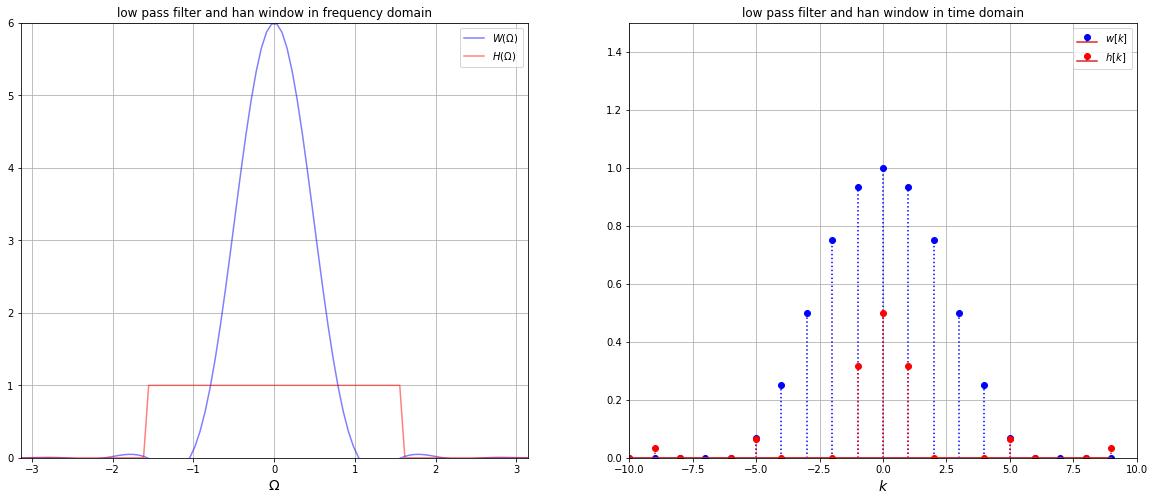

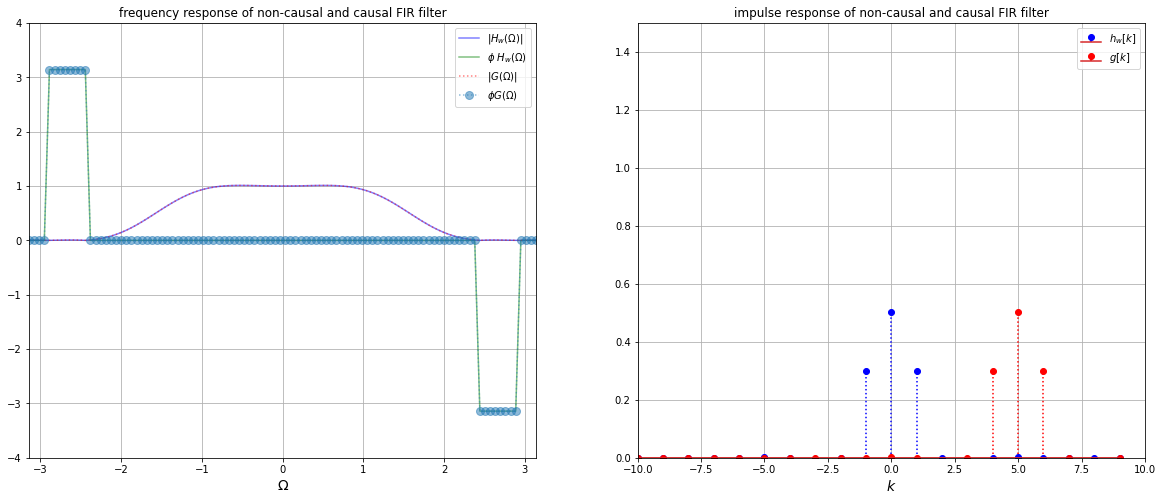

In [3]:
plot2()

You may notice odd behaviour in the phase response. This is an artifact of the limited numerical precision that computers possess.

## IIR Filter design

### Butterworth filter

We follow the example on page 62 in the lecture notes (as of 2020).

Discrete-time IIR filters are usually defined in two step, first a continuous-time filter is designed which is then transformed into a discrete-time filter.

A continuous time Butterworth filter of order $N$ and cut-off (-3dB) frequency $\omega_c$ is defined by its transfer function
$$H(s) = \frac{1}{\prod\limits_{k=1}^N (1-s/p_k)}\quad p_k = \omega_c e^{i \frac{\pi}{2N} (2k+N-1)} \quad\quad\quad\quad\quad |H(i\omega)|^2 = \frac{1}{1+(\omega/\omega_c)^{2N}}$$

In [4]:
pip install pydsm

In [5]:
import ipywidgets as widgets
import numpy as np
from pydsm.ft import idtft
import matplotlib.pyplot as plt
%matplotlib inline
#-------------------------------------------------------------------------------

#Important Stuff
################################################################################
def H_cont(s, N, omega_c):
  prod = 1
  for k in range(1,N+1):
    p_k = omega_c * np.exp(1j*np.pi*(2*k+N-1)/(2*N))
    prod *= (1 - s/p_k)
  return 1/prod
################################################################################

NG, omega_cG = 1, 40*np.pi
logPlotG2 = False
#read in properties
def set_iir_filter(N, f_c, logPlot):
  global NG, omega_cG, logPlotG2
  NG, omega_cG, logPlotG2 = N, f_c * 2*np.pi, logPlot
widgets.interact(set_iir_filter, N = widgets.IntSlider(min=1, max=20, value=4, step=1), f_c = widgets.FloatSlider(min=1, max=100, value=20), logPlot = widgets.Checkbox(value=False, description='logarithmic plot'));

def plot3():
  f_values = np.arange(-150, 150+1)
  H_values = [H_cont(2j*np.pi*f, NG, omega_cG) for f in f_values]
  fig = plt.figure(figsize=(20, 8))

  ax = fig.add_subplot(1, 2, 1)
  ax.grid()
  ax.set_title('magnitude response of H')
  ax.set_xlabel('$f$', fontsize=14)
  ax.set_ylabel('$|H(2\pi f)|$', fontsize=14)
  if logPlotG2 == False:
    ax.axis(xmin=-150, xmax=150, ymin=0, ymax=2)
    ax.plot(f_values, np.abs(H_values), 'g', alpha=0.5, markersize=8);
  else:
    ax.axis(xmin=-150, xmax=150, ymin=0.1, ymax=2)
    ax.semilogy(f_values, np.abs(H_values), 'g', alpha=0.5, markersize=8);

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.grid()
  ax2.set_title('phase response of H')
  ax2.set_xlabel('$f$', fontsize=14)
  ax2.set_ylabel('$\phi\ H(2\pi f)$', fontsize=14)
  if logPlotG2 == False:
    ax2.axis(xmin=-150, xmax=150, ymin=-4, ymax=4)
    ax2.plot(f_values, np.angle(H_values), 'g', alpha=0.5, markersize=8);
  else:
    ax2.axis(xmin=-150, xmax=150, ymin=0.4, ymax=4)
    ax2.semilogy(f_values, np.angle(H_values), 'g', alpha=0.5, markersize=8);

interactive(children=(IntSlider(value=4, description='N', max=20, min=1), FloatSlider(value=20.0, description=…

Try setting different values to adjust the continuous-time butterworth filter to your needs.

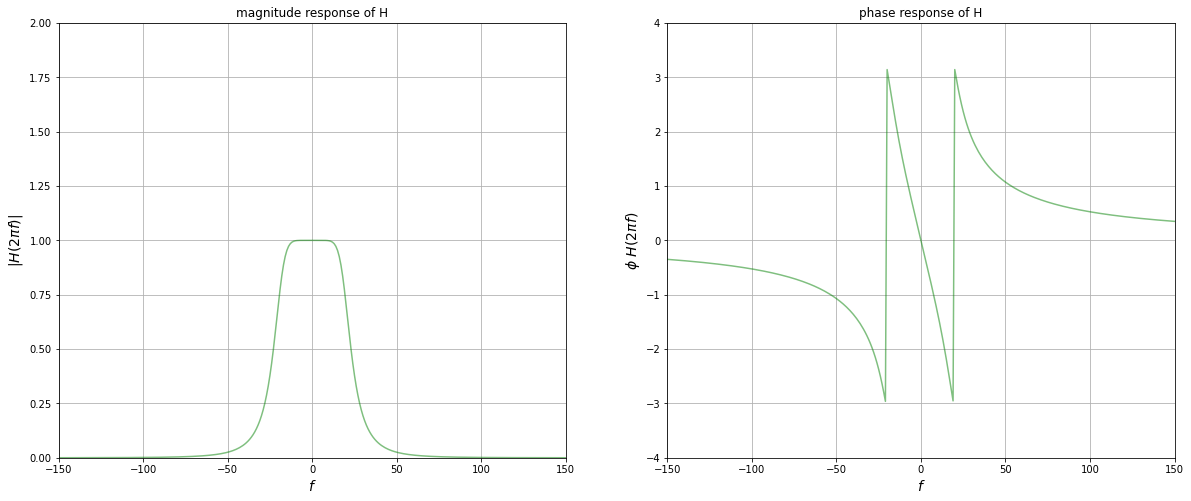

In [6]:
plot3()

### Bilinear Transform

The bilinear transform allows us to transform any continuous-time filter to a discrete-time filter. It utilizes a bijective mapping 
$$\mathbb{C} \to \mathbb{C} : z \mapsto s = \frac{2}{\tau}\frac{1-z^{-1}}{1+ z^{-1}}$$ where $\tau$ is a freely choosable parameter to map the $s$-plane to the $z$ plane. The imaginary axis ends up on the unit circle, the left half plane inside the unit circle and the right half plane outside the unit circle.

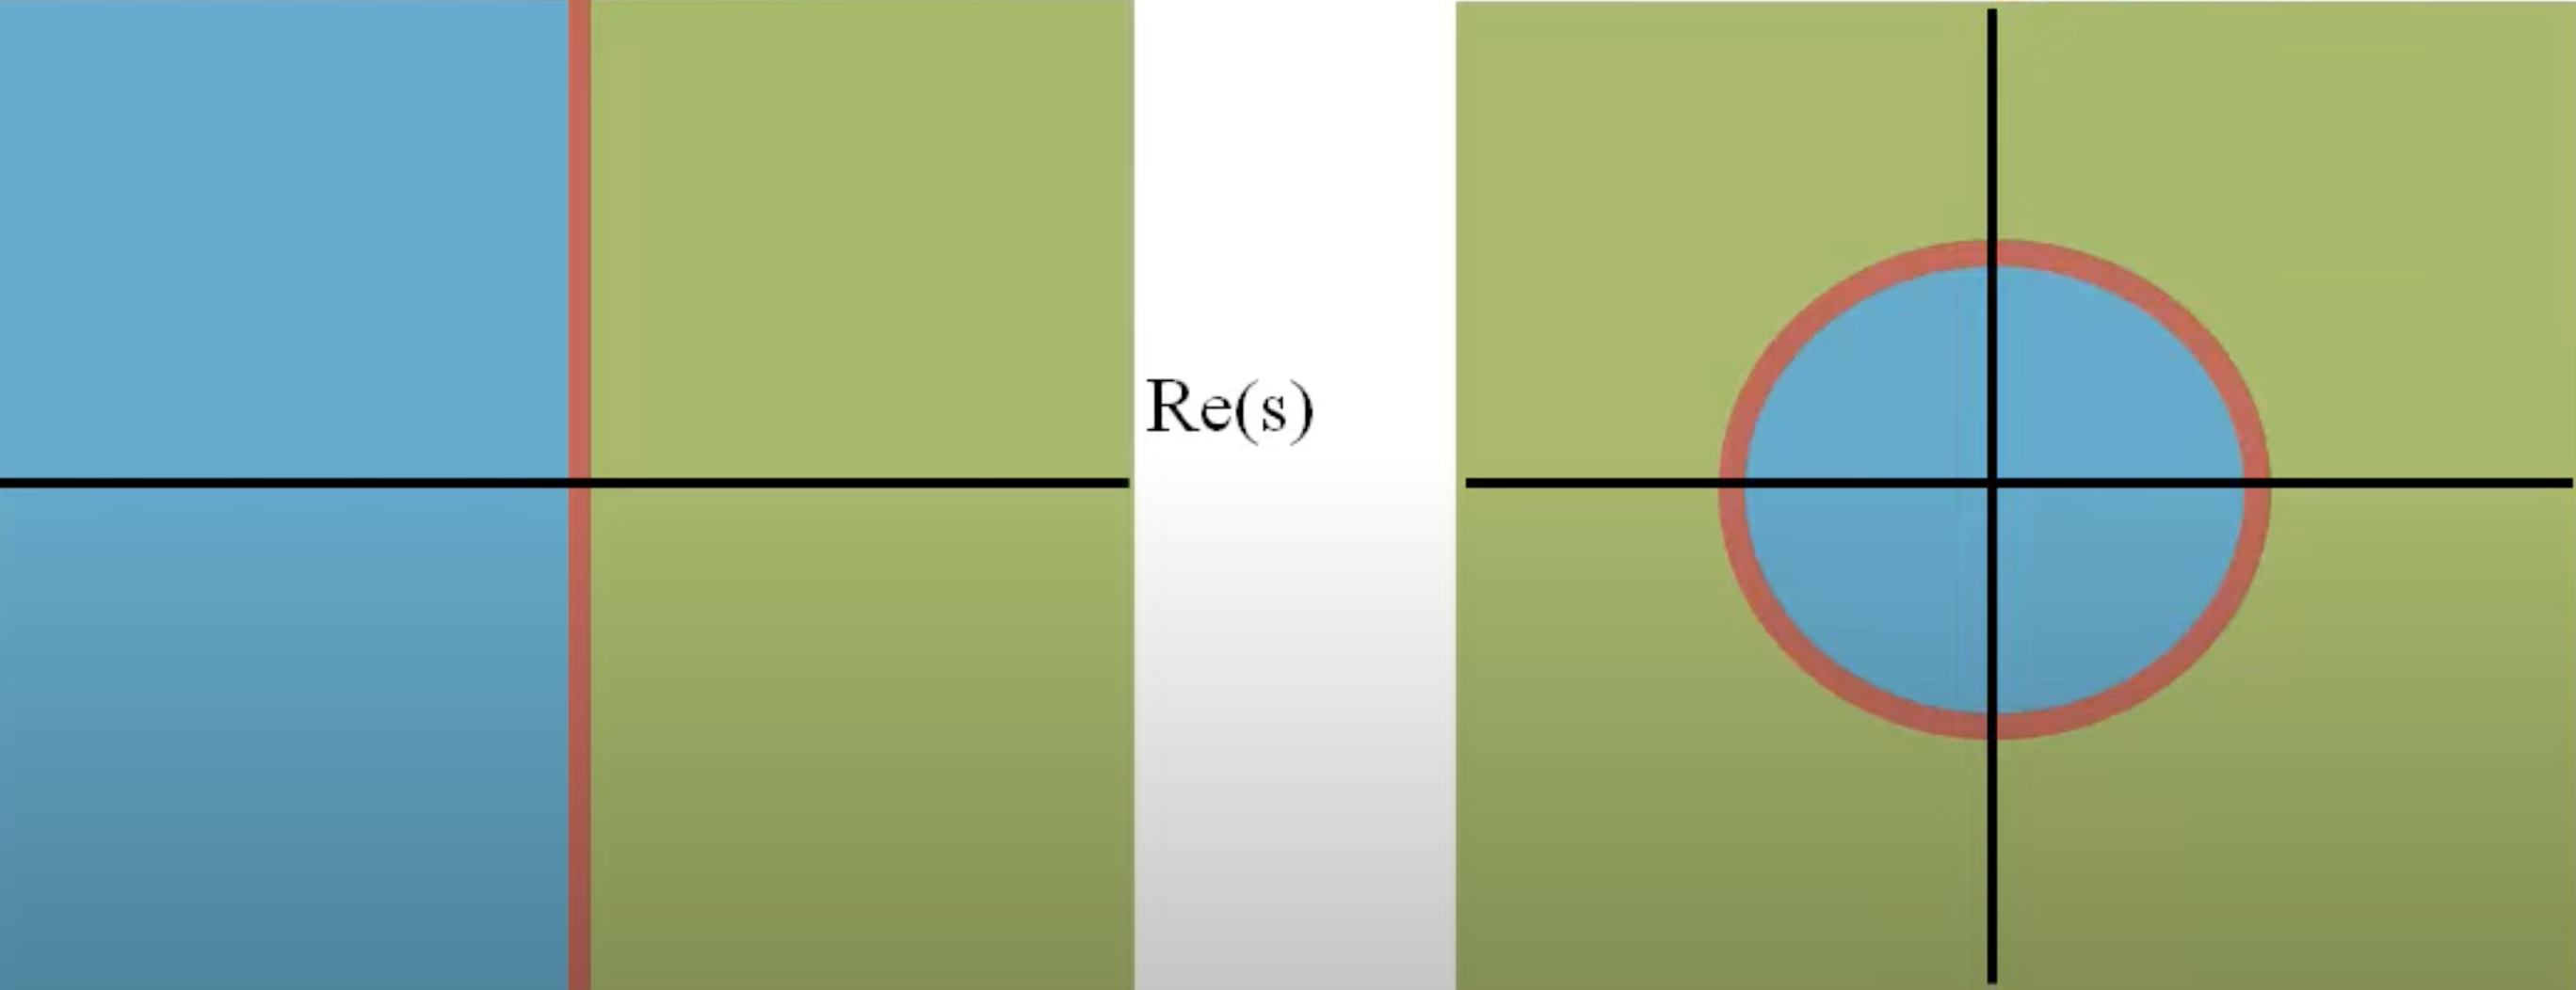


We know that a discrete time filter's frequency response depends on the value the transfer function takes on the unit circle. Similarly the butterworth filter's frequency response depended on the value its transfer function took on the imaginary axis. Therefore we will get similar behaviour invoking the bilinear transformation. However, squeezing an infinite line into a finite segment is not a linear operation as visible below.

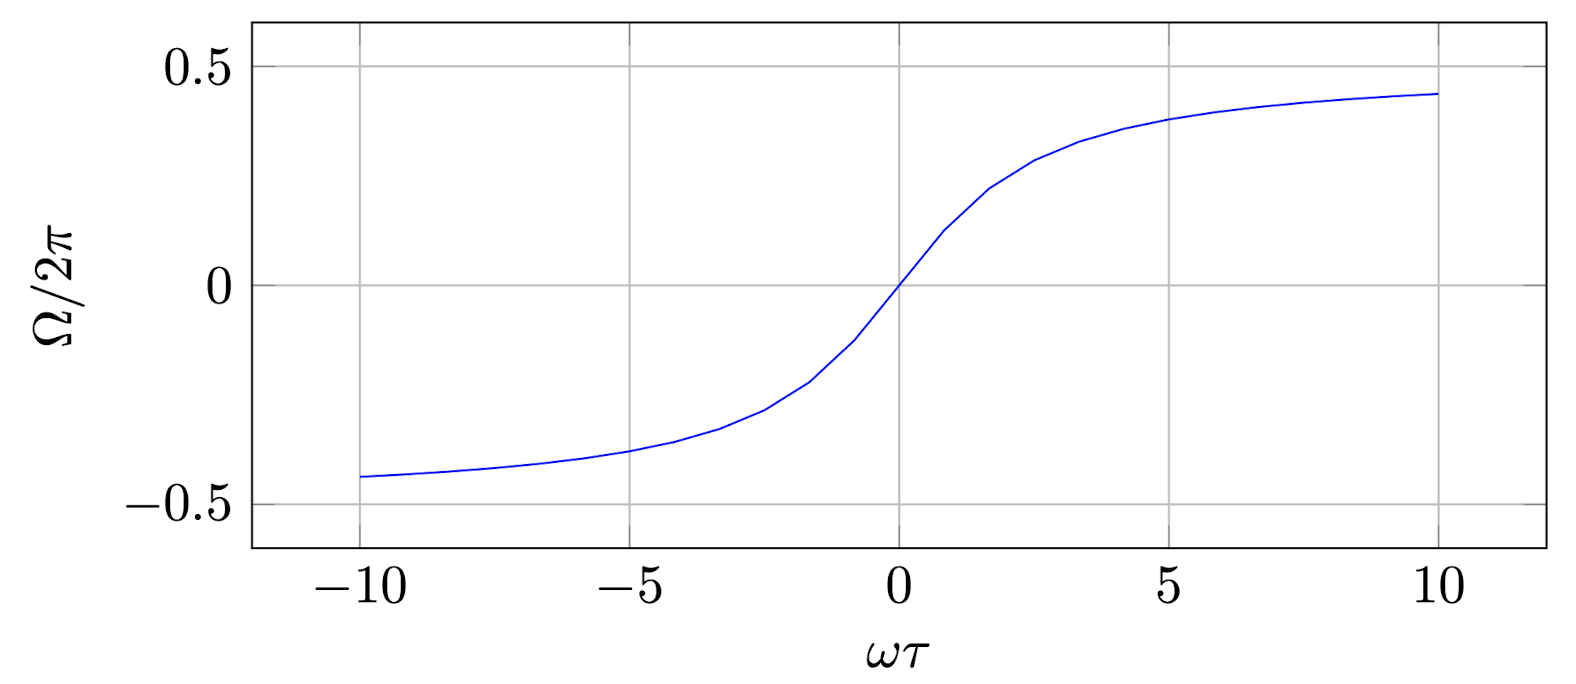

The parameter $\tau$ may be used to stretch this nonlinear behaviour. Even with a fixed butterworth filter $\tau$ may still set the cut-off frequency.
$$\Omega = 2 \tan^{-1} (\frac{\omega \tau}{2}) \quad\text{ which holds in particular for $\Omega_c$ and $\omega_c$}$$
So, below you will find the code which transforms the butterworth filter we designed above into a discrete time filter with adjustable $\tau$.

In [7]:
#Important Stuff
################################################################################
#discrete time transfer function
def H_disc(z, N, omega_c, tau):
  s = (2/tau) * (1-1/z)/(1+1/z) #bilinear transform
  return H_cont(s, N, omega_c) #continuous time transfer function

def h_disc(k, N, omega_c, tau):
  func = lambda Omega: H_disc(np.exp(1j*Omega), N, omega_c, tau) #callable object
  return idtft(func, k, fs = 2*np.pi) #sets f_s such that f=Omega
################################################################################

tauG = 20
logPlotG3 = False
def set_transformation_tau(i_tau, logPlot):
  global tauG, logPlotG3
  tauG, logPlotG3 = 1/i_tau, logPlot
widgets.interact(set_transformation_tau, i_tau = widgets.FloatSlider(description='1/tau', min=1, max=100, value=20), logPlot = widgets.Checkbox(value=False, description='logarithmic plot'));

#drawing plots
def plot4():
  Omega_values = np.linspace(-np.pi, np.pi, 100)
  k_values = np.arange(-20, 20)

  H_values = [H_disc(np.exp(1j*Omega), NG, omega_cG, tauG) for Omega in Omega_values]
  h_values = [h_disc(k, NG, omega_cG, tauG) for k in k_values]

  fig = plt.figure(figsize=(20, 12))

  ax1 = fig.add_subplot(2, 2, 1)
  ax1.grid()
  ax1.set_title('magnitude response of H')
  ax1.set_xlabel('$\Omega$', fontsize=14)
  ax1_ = fig.add_subplot(2, 2, 2)
  ax1_.grid()
  ax1_.set_title('phase response of H')
  ax1_.set_xlabel('$\Omega$', fontsize=14)
  if logPlotG3 == False:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
    ax1_.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=-4, ymax=4)
    ax1.plot(Omega_values, np.abs(H_values), 'r', alpha=0.5, markersize=8);
    ax1_.plot(Omega_values, np.angle(H_values), 'g', alpha=0.5, markersize=8);
  else:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0.1, ymax=1.5)
    ax1_.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0.1, ymax=4)
    ax1.semilogy(Omega_values, np.abs(H_values), 'r', alpha=0.5, markersize=8);
    ax1_.semilogy(Omega_values, np.angle(H_values), 'g', alpha=0.5, markersize=8);
  ax1.legend(['$|H(\Omega)|$'])
  ax1_.legend(['$\phi\ H(\Omega)$'])


  ax2 = fig.add_subplot(2, 2, 3)
  ax2.grid()
  ax2.set_title('magnitude of impulse response of h')
  ax2.set_xlabel('$k$', fontsize=14)
  ax2_ = fig.add_subplot(2, 2, 4)
  ax2_.grid()
  ax2_.set_title('phase of impulse response of h')
  ax2_.set_xlabel('$k$', fontsize=14)
  if logPlotG3 == False:
    ax2.axis(xmin=k_values[0], xmax=k_values[-1], ymin=0, ymax=1.5)
    ax2_.axis(xmin=k_values[0], xmax=k_values[-1], ymin=-4, ymax=4)
    ax2.set_yscale("linear")
    ax2_.set_yscale("linear")
  else:
    ax2.axis(xmin=k_values[0], xmax=k_values[-1], ymin=0.1, ymax=1.5)
    ax2_.axis(xmin=k_values[0], xmax=k_values[-1], ymin=0.1, ymax=4)
    ax2.set_yscale("log")
    ax2_.set_yscale("log")
  ax2.stem(k_values, np.abs(h_values), linefmt='r:', markerfmt='ro', use_line_collection=True);
  ax2_.stem(k_values, np.angle(h_values), linefmt='g:', markerfmt='ro', use_line_collection=True);
  ax2.legend(['$|h[k]|$'])
  ax2_.legend(['$\phi\ h[k]$'])

interactive(children=(FloatSlider(value=20.0, description='1/tau', min=1.0), Checkbox(value=False, description…

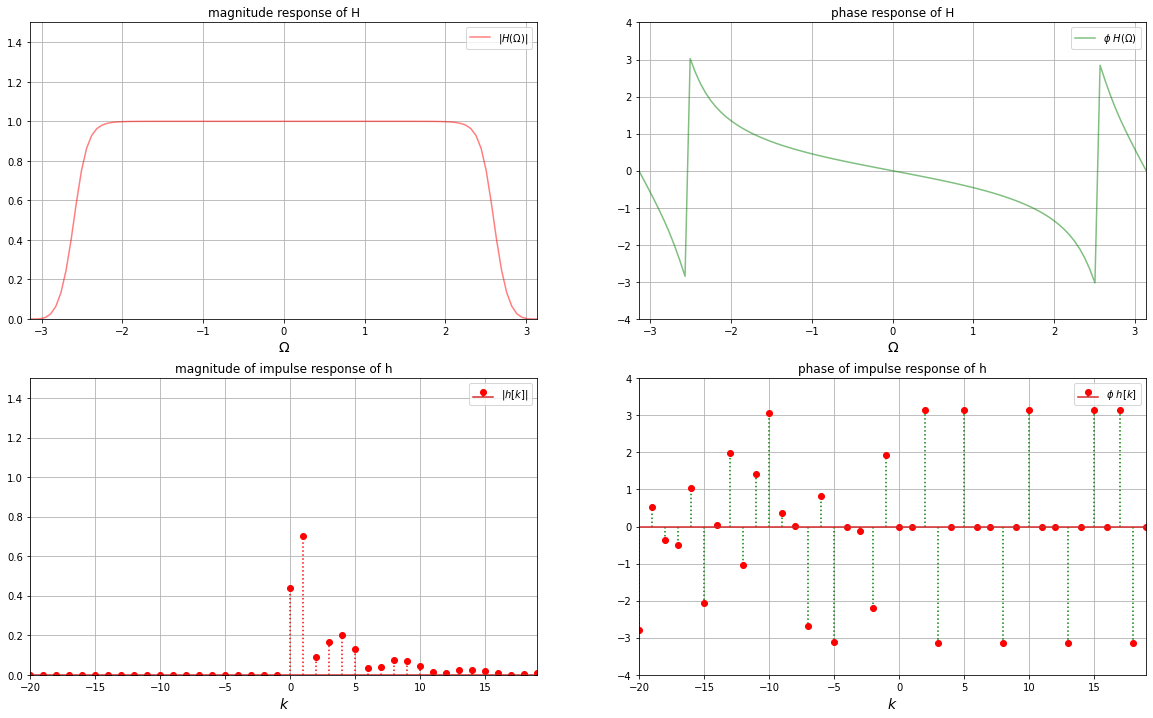

In [8]:
plot4()

As you can see, the Butterworth filter is causal. On the contrary it is not of finite duration (that is why it is called an infinite impulse response filter).